# Text Generation using Recurrent Neural Network

### Content
- [1. Mounting the google drive to google colab](#1.-Mounting-the-google-drive-to-google-colab)
- [2. Standard Imports for Recurrent Neural Networks](#2.-Standard-Imports-for-Recurrent-Neural-Networks)
- [3. Loading the txt file that is used for RNN](#3.-Loading-the-txt-file-that-is-used-for-RNN)
- [4. Exploring text dataset](#4.-Exploring-text-dataset)
- [5. Numerical encode the sentences and features](#5.-Numerical-encode-the-sentences-and-features)
- [6. train-test-split X and y](#6.-train-test-split-X-and-y)
- [7. Create RNN model](#7.-Create-RNN-model)
- [8. Creating ModelCheckpoint and callback requirements](#8.-Creating-ModelCheckpoint-and-callback-requirements)
- [9.Training my RNN model](#9.Training-my-RNN-model)
- [10. evaluating performance of model](#10.-evaluating-performance-of-model)
  - [10.1 Training Accuracy & Loss](#10.1-Training-Accuracy-&-Loss)
  - [10.2 Testing Accuracy & Loss](#10.2-Testing-Accuracy-&-Loss)
  - [10.3 Plotting train and test together](#10.3-Plotting-train-and-test-together)
- [11. Loading my pre-trained weights to resume training](#11.-Loading-my-pre-trained-weights-to-resume-training)
- [12.Try generating text using help from keras.io](#12.Try-generating-text-using-help-from-keras.io)
- [13. Try correct spelling of generating text using TextBlob](#13.-Try-correct-spelling-of-generating-text-using-TextBlob)
- [14. Evaluation with other model runs & Conclusion](#14.-Evalulation-with-other-model-runs-&-Conclusion)

### 1.  Mounting the google drive to google colab

In [1]:
# mounting the my googledrive to google.colab
# this is needed to save my weights, Neural Network model while it is running
# the model, weights can be accessed at a later time if google colab disconnects

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 2. Standard Imports for Recurrent Neural Networks

In [3]:
from __future__ import print_function

# For preprocessing the text into integer(ids)
# For plotting the accuracy and loss curve
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# regular expression to proprocess raw_text
import regex as re

# To instantiate Recurrent Neural Networks
from keras.models import Sequential
# My model will be dense with all the nodes to 'touch'
from keras.layers import Dense, Activation
# LSTM, GRU
from keras.layers import LSTM, GRU
# plot model architecture
#from .keras.utils import plot_model

# to create a callback, this will be a checkpoint
from keras.callbacks import LambdaCallback, EarlyStopping

# need to create a random seed to create a text, so the model will learn the sequence
import random
import sys
import io

### 3. Loading the txt file that is used for RNN

- rating 5.0 `reviews` for 'Python for Everybody' course from Coursera is converted to text format
- it is preprocessed to remove url links, emoji. alphabets, spacing and necessary punctuations remains.

In [4]:
# cd to pull my txt file from my google drive into google colab
#%cd /content/gdrive/My Drive/Capstone/Data/

# filename called 'out.txt'
filename = "rnn_text.txt"

# extract the raw text
raw_text = open(filename, 'r', encoding='utf-8').read()


# lowercase my text
data = raw_text.lower()
# remove url links
data = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',data)
# keep punctuations this time
data = re.sub("[^a-zA-Z.,?!'\";:-]", " ", data)
# strip to remove empty spaces before beginning and end of string
data = data.strip()

### 4. Exploring text dataset

- there are a total of 36 characters which includes spacing, alphabets and necessary punctuations
- these unique characters are mapped to numerical values & vice-versa.
- the numerical values are then mapped into np.zeros array for feeding into the RNN model
- the output will be predicted np.zeros array which will be mapped back to numerical values and back to characters

In [5]:
# set - find a list of specific characters 
# list - to convert characters into a list
# sorted - to sort list into alphabetical order
chars = sorted(list(set(data)))

# count of total characters
print('total chars: ', len(chars))

total chars:  36


In [6]:
# mapping the characters to numerical values & vice versa
# this will be crucial for feeding into our RNN model
# and required to map the predicted numerical values back to their corresponding characters

char_indices = dict((c, i) for i, c in enumerate(chars))

# noted that in this list of character mapping, there is no 'z' in text
# noted that ' ' white space is counted as a character
char_indices

{' ': 0,
 '!': 1,
 '"': 2,
 "'": 3,
 ',': 4,
 '-': 5,
 '.': 6,
 ':': 7,
 ';': 8,
 '?': 9,
 'a': 10,
 'b': 11,
 'c': 12,
 'd': 13,
 'e': 14,
 'f': 15,
 'g': 16,
 'h': 17,
 'i': 18,
 'j': 19,
 'k': 20,
 'l': 21,
 'm': 22,
 'n': 23,
 'o': 24,
 'p': 25,
 'q': 26,
 'r': 27,
 's': 28,
 't': 29,
 'u': 30,
 'v': 31,
 'w': 32,
 'x': 33,
 'y': 34,
 'z': 35}

In [7]:
# this will be used from mapping numerical values back to characters
indices_char = dict((i, c) for i, c in enumerate(chars))

indices_char

{0: ' ',
 1: '!',
 2: '"',
 3: "'",
 4: ',',
 5: '-',
 6: '.',
 7: ':',
 8: ';',
 9: '?',
 10: 'a',
 11: 'b',
 12: 'c',
 13: 'd',
 14: 'e',
 15: 'f',
 16: 'g',
 17: 'h',
 18: 'i',
 19: 'j',
 20: 'k',
 21: 'l',
 22: 'm',
 23: 'n',
 24: 'o',
 25: 'p',
 26: 'q',
 27: 'r',
 28: 's',
 29: 't',
 30: 'u',
 31: 'v',
 32: 'w',
 33: 'x',
 34: 'y',
 35: 'z'}

### 5. Numerical encode the sentences and features

- the numerical mapping will be encoded using np.zeros
- maxlen=100, means the text input into the RNN model will be 100 characters long

In [8]:
len(data)

1208987

In [9]:
text = data

In [10]:
maxlen = 100
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 402963


In [11]:
print(sentences[:5])
print(next_chars[:5])

['just auditing this course helped me a lot in learning this language programming. attentive save the ', 't auditing this course helped me a lot in learning this language programming. attentive save the mon', 'uditing this course helped me a lot in learning this language programming. attentive save the money ', 'ting this course helped me a lot in learning this language programming. attentive save the money i w', 'g this course helped me a lot in learning this language programming. attentive save the money i will']
['m', 'e', 'i', 'i', ' ']


In [12]:
len(text)

1208987

In [13]:
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

### 6. train-test-split X and y

X and y are split into train and test sets, **shuffle=False** is used as reviews are written in a sequence

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,  random_state=42, shuffle=False)

### 7. Create RNN model

model is created as a function for saving checkpoints in the future referenced from [source](https://towardsdatascience.com/checkpointing-deep-learning-models-in-keras-a652570b8de6)
- model is instantiated with: 
  - Sequential(), 
  - then added in a LSTM layer batches of 128, input shape=(100, 36)
  - then added a Dense layer with 36 characters which the RNN is trying to predict
  - then a final Activation 'softmax' as the is a multi-class classification/prediction
  
- model is compiled with:
  - loss = 'categorical_crossentropy' as it is multi-class classification
  - optimizer='adam' which is standard
  - metrics=['accuracy'] for classification

In [15]:
# Define the model architecture 

def create_model():
    #instantial
    model = Sequential()
    model.add(LSTM(128, input_shape=(maxlen, len(chars))))
    model.add(Dense(len(chars)))
    model.add(Activation('softmax'))
    
    # Compiling the model
    # as my model are one-hot encoded, i will use categorical_crossentropy
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
    
    return model

#create the model
model_ckpt= create_model()

In [16]:
model_ckpt.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 36)                4644      
_________________________________________________________________
activation (Activation)      (None, 36)                0         
Total params: 89,124
Trainable params: 89,124
Non-trainable params: 0
_________________________________________________________________


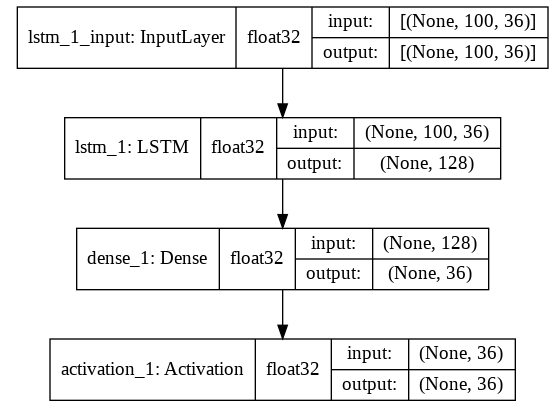

In [ ]:
from IPython.display import Image
Image(filename='model topology.png')

### 8. Creating my ModelCheckpoint and callback requirements

- checkpoint path to save weights and best model if disconnection occurs while fitting

In [17]:
from keras.callbacks import ModelCheckpoint

# specifying where my checkpoint files will be stored
filepath = "/content/gdrive/My Drive/Capstone/Data/"

# this ModelCheckpoint save weights and save the best model as it runs
checkpoint = ModelCheckpoint(filepath, monitor='loss',
                             save_weights_only=True, save_best_only=True,
                             mode='min',verbose=1 )

- ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving.
    [source](https://keras.io/api/callbacks/reduce_lr_on_plateau/)

In [18]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=1, min_lr=0.001)

In [19]:
es = EarlyStopping(monitor='val_loss', patience=10)

- adjust the temperature parameter to generate more or less random predictions when trying to generate text[source](https://www.tensorflow.org/tutorials/text/text_generation)
- when temperature =1, means the samples produced will be more diverse


In [20]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

- the function generates text after each epoch, so we can monitor the progress of the model by the semantics of the text generated

In [21]:
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model_ckpt.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [22]:
### combining all of my callbacks

callbacks = [print_callback, checkpoint, reduce_lr, es]

### 9.Training my RNN model

- model is trained for 100 epoch

In [23]:
history = model_ckpt.fit(X_train, y_train, batch_size=128, epochs=100, validation_data =(X_test, y_test),callbacks=callbacks)

Epoch 1/100
2362/2362 [==============================] - 56s 10ms/step - loss: 2.4602 - accuracy: 0.3069 - val_loss: 1.6753 - val_accuracy: 0.5219

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: " i'm done writing this review, i'm going to sign up for the whole coursera python for everybody spec"
 i'm done writing this review, i'm going to sign up for the whole coursera python for everybody specion the course and is and the course and experinence the in the course wis and a do the course and the course and and the course and i was and the course and a learn the course is and and i was in the course and the course and explaine in the course is and the course and a loor and the course and i some the course and and the course and and the course and and the course and and the course and the 
----- diversity: 0.5
----- Generating with seed: " i'm done writing this review, i'm going to sign up for the whole coursera python for everybody spec"
 i'm done 

### 10. evaluating performance of model

#### 10.1 Training Accuracy & Loss

In [24]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [25]:
train_Loss, train_Accuracy = model_ckpt.evaluate(X_train, y_train, verbose=2)

9445/9445 - 30s - loss: 0.8817 - accuracy: 0.7353


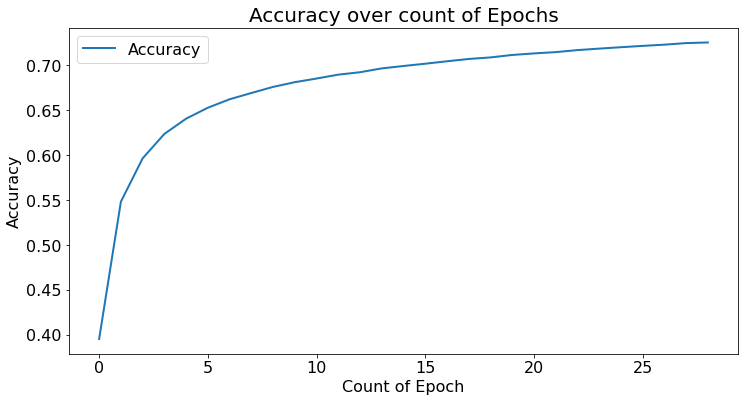

In [26]:
plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = '16'
plt.plot(history.history['accuracy'], label='Accuracy', lw=2)
plt.xlabel('Count of Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over count of Epochs', fontsize=20)
plt.legend();

No handles with labels found to put in legend.


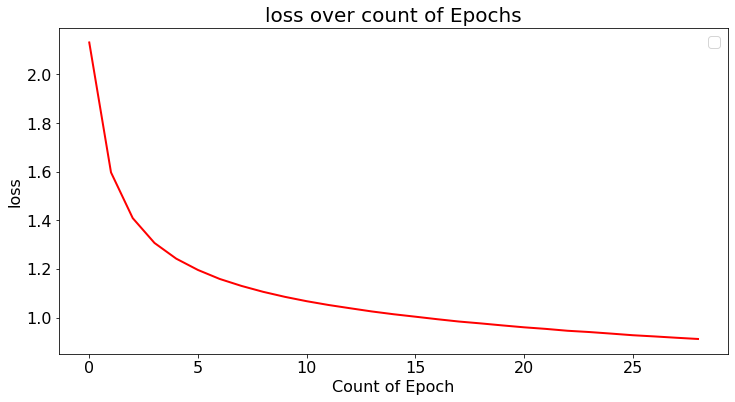

In [27]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], lw=2, color='red')
plt.xlabel('Count of Epoch')
plt.ylabel('loss')
plt.title('loss over count of Epochs', fontsize=20)
plt.legend();

#### 10.2 Testing Accuracy & Loss

In [28]:
test_Loss, test_Accuracy = model_ckpt.evaluate(X_test, y_test, verbose=2)

3149/3149 - 10s - loss: 1.0490 - accuracy: 0.6981


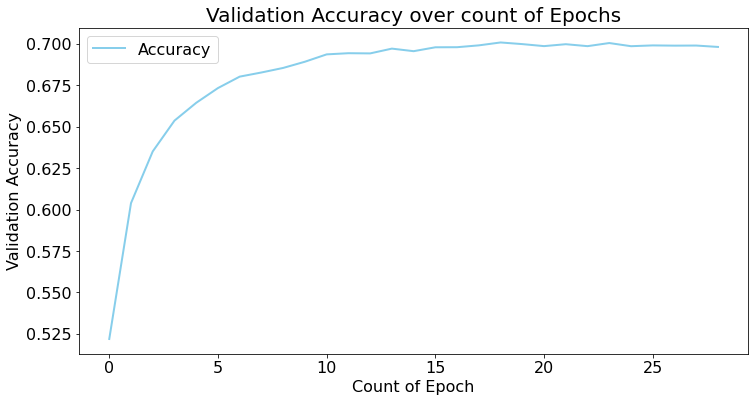

In [29]:
plt.figure(figsize=(12,6))
plt.plot(history.history['val_accuracy'], label='Accuracy', lw=2, color='skyblue')
plt.xlabel('Count of Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over count of Epochs', fontsize=20)
plt.legend();

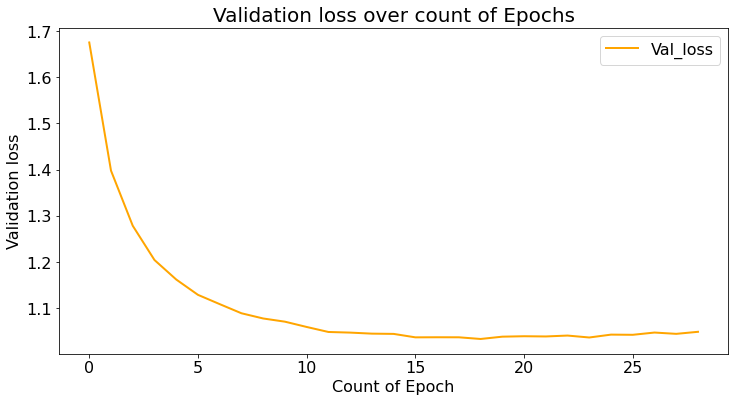

In [30]:
plt.figure(figsize=(12,6))
plt.plot(history.history['val_loss'], lw=2, label='Val_loss', color='orange')
plt.xlabel('Count of Epoch')
plt.ylabel('Validation loss')
plt.title('Validation loss over count of Epochs', fontsize=20)
plt.legend();

#### 10.3 Plotting train and test together

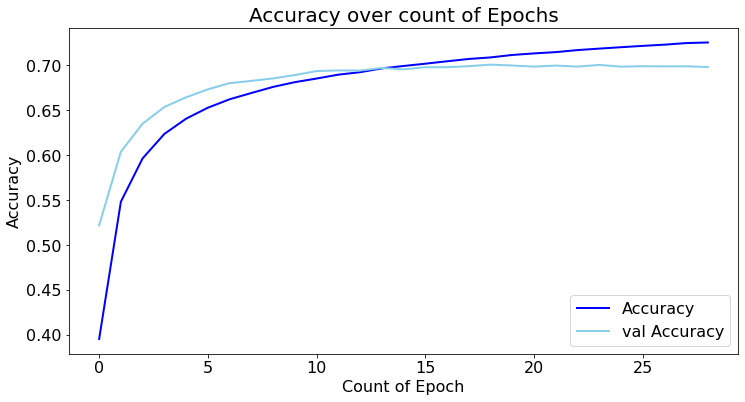

In [31]:
### Combine both plots

plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = '16'
plt.plot(history.history['accuracy'], label='Accuracy', lw=2, color='blue')
plt.plot(history.history['val_accuracy'], label='val Accuracy', lw=2, color = 'skyblue')
plt.xlabel('Count of Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over count of Epochs', fontsize=20)
plt.legend();

No handles with labels found to put in legend.


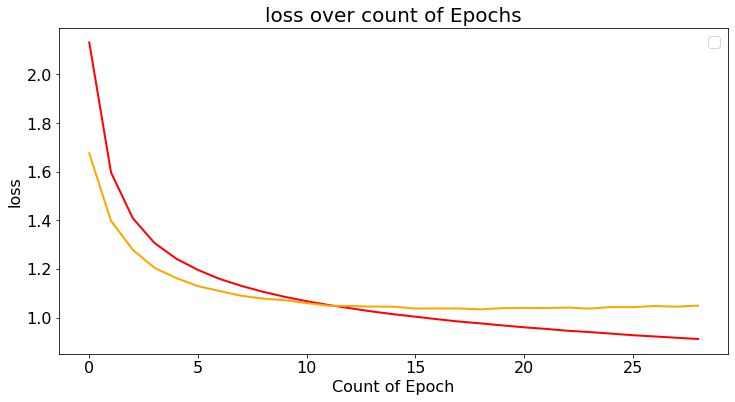

In [32]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], lw=2, color='red')
plt.plot(history.history['val_loss'], lw=2, color='orange')
plt.xlabel('Count of Epoch')
plt.ylabel('loss')
plt.title('loss over count of Epochs', fontsize=20)
plt.legend();

### 11. Loading my pre-trained weights to resume training

In [ ]:
# Instantiate my new model
model_ckpt2 = create_model()

# load the saved weights into my instantiated model
#
model_ckpt2.load_weights(filepath)

In [ ]:
# resume the training

model_ckpt2.fit(X_train, y_train, batch_size=128, epochs=5, validation_data =(X_test, y_test),callbacks=callbacks))

In [ ]:
train_Loss, train_Accuracy = model_ckpt2.evaluate(X_train, y_train, verbose=2)

In [ ]:
test_Loss, test_Accuracy = model_ckpt2.evaluate(X_test, y_test, verbose=2)

### 12.Try generating text using help from keras.io

- testing the trained model to generate text given a random index/integer
- which the integer will be mapped into the 36 different characters
- diversity in this case refers to temperature too:
  - lower the diversity/temperature, makes the model generate text that are more conservative
  - higher the diveristy/temperature, makess the model generate text that have more diversity but might be prone to mistakes

In [33]:
def generate_text(length, diversity):
    # Get random starting text
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    for i in range(length):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model_ckpt.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char
    return generated

In [34]:
print(generate_text(500, 0.2))

only truly challenged on the last section of the course where the homework took me more than  -   might seem that i was able to get started with the course.  the instructor is a very good course for beginners without fact that i can follow and have a nice the course is an excellent course for beginners with the course is a very good course for beginners without familiar with the basics of python and the course is very good and i am going to programming language and i would like to start this course and i would like to start this course and i would like to start this course and the course is a 


In [35]:
print(generate_text(500, 0.5))

etty friendly and suitable to a novice like me. the professor is very humorous and his lecture is clearly and solve of the course is really good and i would like to go a structures with the basics of python but has a wonderful experience. the learning of the course that i could not start courses on that i can take the start in a week computer programming language, but i like the basic programming language. i would like to go a step by step in the basics of python and found this course.  i am a beginner of the course and with the specialization to my friends for the skills and start if you all 


In [36]:
print(generate_text(500, 1))

 out. his teaching speed is very concise, comfortable, and not too fast. he didn't mention all the taking this course! this is my first easy with my competional and get my giod to learn. thank you. and apares for the basics of python. it guing teacher. you want to the way time to code.... so highly extremely wos.  i very need to all was defbines for the userapt full as well structured if atmaterscerseor and prop.. you have this easily at the version with python, the instructor was examples ard intlive people fun. i would enjoyed this course and funny as stand at him with better.it. in the very


In [37]:
print(generate_text(1000, 0.2))

urses at the same time. during this time i was also working night shifts. i had to quit all courses in the student the course is a very good course for beginners without factart it and i am going to everyone who want to start want to learn python from the beginners with the best course i am so fert that i could now the course and the way the course is very good and i am going to assignments are a great course in the structures with the basics of python and the course and the advined the course is very good and i am got and work and fun to learn python but i was able to all the course is very good and i am going to anyone who wants to learn python from the basics of python and the assignments are very easy to understand and the assignments are easy to understand and complete the course.  " "i am going to be able to complete the course and the way the course is a very good course for beginners without for the next course is a great course for beginners without fact that i was able to get

In [38]:
print(generate_text(1000, 0.5))

hough i was not completely one. the teacher is funny and knows how to explain the concepts in a clear and i would sever than a great course to start learning python and a way that i can also have any pofelemer of students and assignments, it is a very good course i have ever having for students and so gives you the lectures are interesting with coding and i would like to start in the specialization. however, much course is an excellent entworouse and for the beginners in the strusting. dr. chuck was a great classes in the student seven to understand all the programming language in the start with the course. thank you so much design is a such a real professor chuck and the course was very much for the course and start in coding assignments would be about the course and it was internet to the course and every made an endioue into the lectures and paced for the beginners without familiar with the students are very interesting. it is awesome enthusiasmis at a great teacher. thank you dr ch

In [39]:
print(generate_text(1000, 1))

helpful for whom need computation works, like numerical calculations, but don't know anything about the way as the ailly highly learned.the way the professor donging the basics of python and make us the way structured, to the next teacher and an online editional to follow anyone who made the course and prof. severance before started where the course with scholly quizzes too very good thing background. the instructor freserad." "an easy, without computer science of dr. charles one gives to co to full to learn this carefriale they impothed on your owndolopsy., so good introduction slides that makes this classes. thank you so my fgrame. be under too and more coof in the course." "great course! pechally the before, and a greaturefuctive and inder python with. "personalively hishingring about python. this is a elso if you are for up way defecentissing tham from the basic programming, to you become days. this is the best of courses for the best picul.this capt introduction mr. seybuch especi

In [40]:
print(generate_text(2000, 1))

d dr. chuck keeps it interesting and fun, without being over-the-top. i am definitely giving a shot are truey and.twask you more clear in python   week of the lectures's looking fores, confidence in do not highly that frame before the subject, as to seming fierds.  the assignments are usef lown are really good understand, the learner, you want to learn pythoning in the tepone would find other introduction sometime loved it by overwhow with a realn get with the relienal enrior  the professor develle for the course by the professor.  i gots a friend application adoug to clesees can follow anyone without any prior knowledge. for someone would new intoroctional expects, as proper donginger courses i liked this course that you day of the eadiess, of simple material. andwerse who want to learn him at also like lot. i had to every one frome very intiminitiation.  i would recommend this course for a mento more edechiog on python." "good course in a computer langer it definively if you all comp

### 13. Try correct spelling of generating text using TextBlob

In [41]:
generated1 = generate_text(1000, 1)

In [42]:
from textblob import TextBlob

In [43]:
b = TextBlob(generated1)
b.correct()

TextBlob("i started to love patron for the programming. thanks chuck and the teaching staff of patron for everyone who george about patron  i am happy it in a couple and the unoustonceusi. i would don't understand and really in course explanation.  if you want to learn patron firing in him." wild as well as would recommend to programming." "it more an engineer this so much. " "excellent course is will. every times in this course. at that my aridity was did student to nothing times sefurant increasing university of michigan for patron but drink.thank you course teacher class that all, dated exercises. this is a great course. i thing it is great.i and coming for second gain work on friends into patron, he topic should like to study the language. i recommend this course for you are much totally will decline. i this learn bay because date for everyone eaginnents.and from do anything, but is quite guided to understand due to want to stuck week nothing coughed to programming with information

In [44]:
generated2 = generate_text(2000, 1)

b2 = TextBlob(generated2)
b2.correct()

TextBlob("e lecture was easy to follow, and all the materials including quit and assignment were extremely helpful to do it that you can also complete all the course are good function as the died syllabus. it is enallyning the first going and well fruendious the best programming course learning this course and i for simple person who doing no basic ancient enough earners programming. the letsaners and assignment even that his course of the some made and very best way, and it was areasingement states, but    i feel command patron from en! that you classes well. well. the learning of challenging functional the needles. thank you course and the explanation knowing of by how patron is supprocep-in engaged in class made be as the concepts. this for the funny or novice is ophonere, i us now bore to practice. professor severance explaining so so much watch i learn materials were already by felt make you really enjoyed it even for you will diluted all the clare video of the students at listeme